<h1 style="width:750px">Airbnb and the Prevalence of Ghost Hotels in London</h1>

---

| CASA0013 | Introduction to Programming for Spatial Analysts | 
|----|----|
| Programme | MSc Smart Cities and Urban Analytics |
| Bartlett | Centre for Advanced Spatial Analytics |
| Word Count | 2,500 |
| Student ID | 19140941 |
| Date | 21-01-13 |

---

## Part 1 - Reproducible Analysis

Data for this analysis was downloaded from the Inside Airbnb website at http://insideairbnb.com/get-the-data.html.

| Data Downloaded | |  | |
|----|----|----|----|
|  09 August, 2019  |  London  |  listings.csv.gz  |  Detailed Listings data for London  |
|  N/A  |  London  |  neighbourhoods.csv  |  Neighbourhood list for geo filtering  |
|  N/A  |  London  |  neighbourhoods.geojson  |  GeoJSON file of city neighbourhoods  |

**Note:** 
- With a filesize of 318 MB, the original .csv file was too large for GitHub to accept. 
- The original data set contained 106 columns.
- 97 columns were removed and the remaining 9 columns were saved to a new .csv to be uploaded to GitHub.
- These steps were completed in Excel, but the python the code below could be run instead.

**Steps:**
- Load original .csv
- Create a new dataframe containing only the 9 columns needed for analysis
- Save the new datframe as a .csv file

**Code:**

In [ ]:
# original = pd.read_csv('listings.csv')
# airbnb = original.loc[:, ['id', 'host_id', 'host_about', 'host_neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type']]
# airbnb.to_csv('<Path>\19-08_ab_london.csv', header=True)

- The resulting .csv file is used in the reproducible analysis below.
- The .csv file can be downloaded from GitHub at https://github.com/MattKavanaugh/I2P-Exec-Briefing. 

### Load

In [ ]:
# Load libraries

import pandas as pd
import geopandas as gpd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

In [ ]:
# Load dataframe

airbnb = pd.read_csv('19-08_ab_london.csv',encoding = "Latin-1")
airbnb.head()

#### Review

In [ ]:
# Check number of rows and number of columns
# Check column names
# Check counts
# Check data types

airbnb.info() 

In [ ]:
airbnb.describe()

### Clean

In [ ]:
# We want to change the data type of the 'id' and 'host_id' columns from int64 to object
cols =["id", "host_id"]
airbnb[cols] = airbnb[cols].astype(object)

In [ ]:
# Confirm that the data type of the 'id' and 'host_id' columns has changed to object
airbnb.info()

In [ ]:
# Check for missing values and compare to counts
airbnb.isnull().sum()

In [ ]:
# Replace missing values in 'host_about' column with "Unknown"
airbnb.host_about.fillna("Unknown")

In [ ]:
# Replace missing values in 'host_neighbourhood' column with "Unknown"
airbnb.host_neighbourhood.fillna("Unknown")

### Explore

In [ ]:
# Check how many unique values are there in every column?
airbnb.nunique()

In [ ]:
# What are the 41 different property types?
airbnb['property_type'].unique()

In [ ]:
# What are the 4 different room types?
airbnb['room_type'].unique()

In [ ]:
# What are the 33 different neighbourhoods?
airbnb['neighbourhood_cleansed'].unique()

### Analyze

In [ ]:
# Read in once
nbhoods = gpd.read_file('neighbourhoods.geojson')

In [ ]:
nbhoods['geometry']

In [ ]:
nbhoods.plot()

##### How many Airbnb listings in London are not the primary residence of the host?

In [ ]:
tot_listings = airbnb.id.count()
tot_hosts = airbnb.host_id.nunique()
percent_diff_hvl = ((tot_listings-tot_hosts)/tot_listings)*100
list_diff_hvl = tot_listings-total_hosts
print(f"There were {tot_listings} total listings in London during August 2019.")
print(f"There were {tot_hosts} total hosts in London during August 2019.")
print(f"There were {list_diff_hvl} more listings than hosts in London during August 2019, or {round(percent_diff_hvl)} percent of total listings.")

In [ ]:
ent_home = airbnb.room_type == 'Entire home/apt'
tot_ent_home = ent_home.sum()
percent_diff_ehvl = ((tot_listings-tot_ent_home)/tot_listings)*100
print(f"There were {tot_ent_home} listings offering the entire home or apartment in London during August 2019, or {round(percent_diff_ehvl)} percent of total listings.")

In [ ]:
for n in ent_home:
    print(airbnb.host_id.nunique.sum())

##### How many Airbnb listings in London can be attributed to hosts with multiple listings?

In [210]:
top_hosts = airbnb['host_id'].value_counts().head(10)
print(top_hosts)

airbnb.host_id.count()

#len(airbnb.host_id)

#avg = sum(airbnb.host_id)/len(airbnb.host_id)
#print("The average is ", round(avg, 2))

33889201     1175
156158778     243
28820321      223
48165024      180
137094377     163
1432477       162
224866971     157
27572615      138
13557337      118
50291093      113
Name: host_id, dtype: int64


85918

[Text(0, 0, '33889201'),
 Text(1, 0, '156158778'),
 Text(2, 0, '28820321'),
 Text(3, 0, '48165024'),
 Text(4, 0, '137094377'),
 Text(5, 0, '1432477'),
 Text(6, 0, '224866971'),
 Text(7, 0, '27572615'),
 Text(8, 0, '13557337'),
 Text(9, 0, '50291093')]

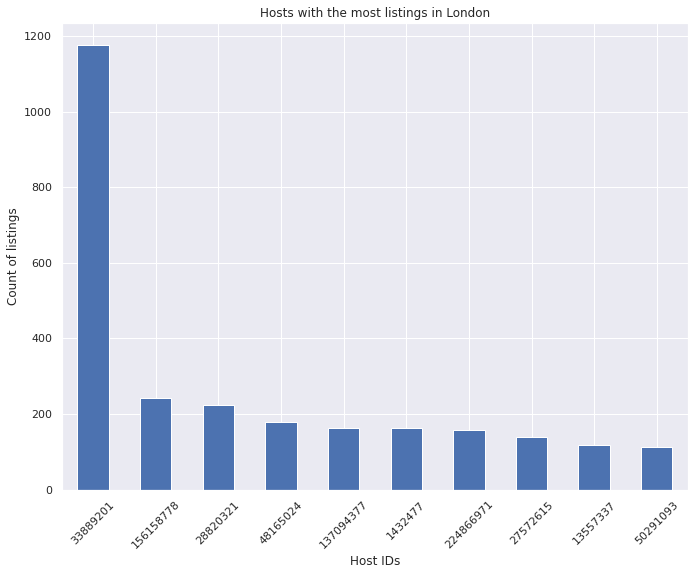

In [195]:
top_hosts = airbnb['host_id'].value_counts().head(10)

sns.set(rc={'figure.figsize':(10,8)})

viz_bar = top_hosts.plot(kind='bar')
viz_bar.set_title('Hosts with the most listings in London')
viz_bar.set_xlabel('Host IDs')
viz_bar.set_ylabel('Count of listings')
viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

##### How many Airbnb listings in London are operated by management companies?

In [ ]:
pip install nltk
python -m nltk.downloader all

In [153]:
#pre-processing

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string

def pre_process(corpus):
    # convert input corpus to lower case.
    corpus = corpus.lower()
    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words('english') + list(string.punctuation)
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
   corpus = " ".join([i for i in word_tokenize(corpus) if i not in stopset])
    # remove non-ascii characters
    corpus = unidecode(corpus)
    return corpus

pre_process("Sample of non ASCII: Ceñía. How to remove stopwords and punctuations?")

SyntaxError: invalid syntax (<ipython-input-153-21e8c8037306>, line 1)

In [ ]:
#Lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
words = word_tokenize(sentence)
for w in words:
    print(w, " : ", lemmatizer.lemmatize(w)

In [ ]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
# sentence pair
corpus = ["A girl is styling her hair.", "A girl is brushing her hair."]
for c in range(len(corpus)):
    corpus[c] = pre_process(corpus[c])
# creating vocabulary using uni-gram and bi-gram
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(corpus)
feature_vectors = tfidf_vectorizer.transform(corpus)

In [ ]:
#g. Top listing words example from London – but in host_about

#Crete empty list where we are going to put the name strings
names=[]
#Getting name string from 'name' column and appending it to the empty list
for name in airbnb.name:
    names.append(name)

#Setting a function to split name strings into seperate words
def split_name(name):
    s = str(name).split()
    return s

#Create empty list where we are going to count the words
names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in split_name(n):
        word = word.lower()
        names_count.append(word)

        
from collections import Counter
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

word_count_data = pd.DataFrame(top_25)
word_count_data.rename(columns={0:'Words',1:'Counts'},inplace=True)
viz_count = sns.barplot(x='Words',y='Counts', data = word_count_data)
viz_count.set_title('Top 25 used words for listing names')
viz_count.set_ylabel('Count of words')
viz_count.set_xlabel('Words')
viz_count.set_xticklabels(viz_count.get_xticklabels(),rotation = 90)

##### Is the problem of 'ghost hotels' concentrated in certain areas of London or spread throughout?

In [162]:
top_nbhoods = airbnb['neighbourhood_cleansed'].value_counts().head(10)
print(top_nbhoods)

Westminster               9757
Tower Hamlets             8299
Hackney                   6244
Camden                    6090
Kensington and Chelsea    5961
Islington                 5240
Southwark                 4953
Lambeth                   4890
Wandsworth                4328
Hammersmith and Fulham    4320
Name: neighbourhood_cleansed, dtype: int64


[Text(0, 0, 'Westminster'),
 Text(1, 0, 'Tower Hamlets'),
 Text(2, 0, 'Hackney'),
 Text(3, 0, 'Camden'),
 Text(4, 0, 'Kensington and Chelsea'),
 Text(5, 0, 'Islington'),
 Text(6, 0, 'Southwark'),
 Text(7, 0, 'Lambeth'),
 Text(8, 0, 'Wandsworth'),
 Text(9, 0, 'Hammersmith and Fulham')]

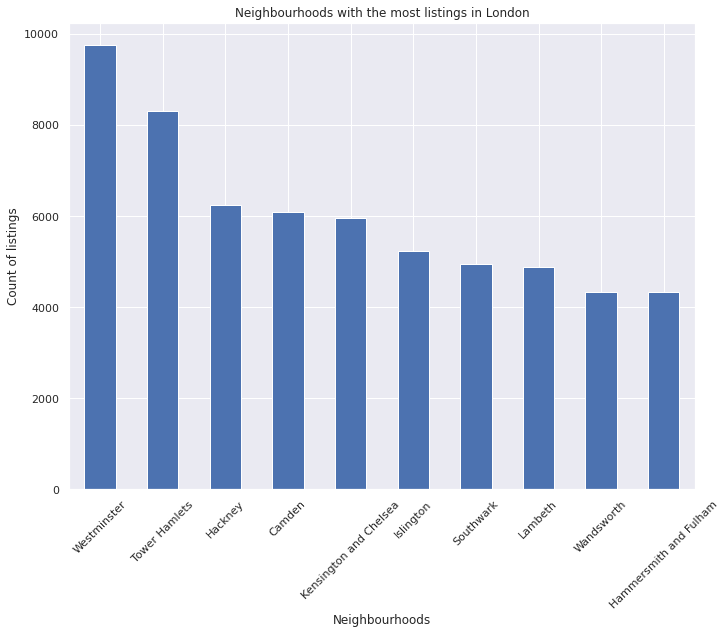

In [194]:
top_nbhoods= airbnb['neighbourhood_cleansed'].value_counts().head(10)

sns.set(rc={'figure.figsize':(10,8)})

viz_bar = top_nbhoods.plot(kind='bar')
viz_bar.set_title('Neighbourhoods with the most listings in London')
viz_bar.set_xlabel('Neighbourhoods')
viz_bar.set_ylabel('Count of listings')
viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

In [65]:
coord = airbnb.loc[:,['longitude','latitude']]
coord.describe()

,longitude,latitude
count,85918.000000,85918.000000
mean,-0.127892,51.509576
std,0.092198,0.046265
min,-0.495820,51.294790
25%,-0.188020,51.485450
50%,-0.125660,51.514040
75%,-0.070000,51.537330
max,0.296570,51.681690


In [192]:
plt.figure(figsize=(18,12))
plt.style.use('fivethirtyeight')
BBox = (-0.4958, 0.2966, 51.2948, 51.6817)
ldn_map = json('neighbourhoods.geojson')
plt.imshow(ldn_map,zorder=0,extent=BBox)
ax = plt.gca()
groups = airbnb.groupby('neighbourhood_cleansed')
for name,group in groups :
    plt.scatter(group['longitude'],group['latitude'],label=name,alpha=0.5, edgecolors='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

TypeError: 'module' object is not callable

<Figure size 1296x864 with 0 Axes>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


<Figure size 2160x1800 with 0 Axes>

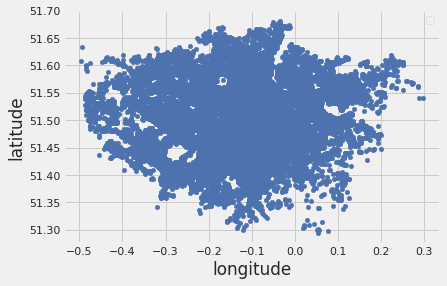

In [191]:
plt.figure(figsize=(30,25))
#plt.title("Map of Price Distribution")
ax=airbnb.plot(kind='scatter', x='longitude',y='latitude')
ax.legend()
plt.ioff()
plt.show()

---

## Part 2 - Executive Briefing

---

### 1 Executive Summary

This report provides an analysis of Airbnb activity in London based on data sourced from the Inside Airbnb website for the month of August 2019 – the last summer month prior to the COVID-19 pandemic. Through exploratory data analysis, we define what a ‘ghost hotel’ is and then set out to answer four main questions:
1. How many Airbnb listings in London are not the primary residence of the host?
2. How many Airbnb listings in London can be attributed to hosts with multiple listings?
3. How many Airbnb listings in London are operated by management companies?
4. Is the problem of ‘ghost hotels’ concentrated in certain areas of London or spread throughout?

#### Key Findings

#### Recommendations

---

### 2 Background

#### Airbnb

#### 'Ghost Hotels'

#### Inside Airbnb

---

### 3 Analysis

#### How many Airbnb listings in London are not the primary residence of the host?

#### How many Airbnb listings in London can be attributed to hosts with multiple listings? 

#### How many Airbnb listings in London are operated by management companies? 

#### Is the problem of 'ghost hotels' concentrated in certain areas of London or spread throughout?

---

### 4 Conclusion

---

### 5 References